In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

bot_paths = [
    'data/social_spambots_1.csv',
    'data/social_spambots_2.csv',
    'data/social_spambots_3.csv'
]

bot_accounts = pd.concat([pd.read_csv(path) for path in bot_paths], ignore_index=True)
clean_accounts = pd.read_csv('data/geniune_accounts.csv')

In [4]:
REQUIRED_COLUMNS = [
    'screen_name', 'created_at', 'updated', 'location', 'verified',
    'statuses_count', 'friends_count', 'followers_count', 'favourites_count',
    'default_profile_image', 'profile_use_background_image',
    'protected', 'default_profile'
]

raw_bot_accounts = pd.concat([
    pd.read_csv('data/social_spambots_1.csv'),
    pd.read_csv('data/social_spambots_2.csv'),
    pd.read_csv('data/social_spambots_3.csv')
], ignore_index=True)

raw_clean_accounts = pd.read_csv('data/geniune_accounts.csv')

print("Raw Bot Columns:", raw_bot_accounts.columns)
print("Raw Clean Columns:", raw_clean_accounts.columns)

def clean_df(df):
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
    df['updated'] = pd.to_datetime(df['updated'], utc=True, errors='coerce')
    df['age'] = (df['updated'] - df['created_at']).dt.days

    df['has_location'] = df['location'].notna().astype(int)
    df['has_avatar'] = df['default_profile_image'].notna().astype(int)
    df['has_background'] = df['profile_use_background_image'].notna().astype(int)
    df['is_verified'] = df['verified'].notna().astype(int)
    df['is_protected'] = df['protected'].notna().astype(int)
    df['profile_modified'] = df['default_profile'].notna().astype(int)

    df = df.rename(columns={
        "screen_name": "username",
        "statuses_count": "total_tweets",
        "friends_count": "total_following",
        "followers_count": "total_followers",
        "favourites_count": "total_likes"
    })

    return df[[
        'username', 'age', 'has_location', 'is_verified',
        'total_tweets', 'total_following', 'total_followers', 'total_likes',
        'has_avatar', 'has_background', 'is_protected', 'profile_modified'
    ]]

bot_accounts = clean_df(raw_bot_accounts)
clean_accounts = clean_df(raw_clean_accounts)

print("Cleaned Bot Accounts Columns:", bot_accounts.columns)
print("Cleaned Clean Accounts Columns:", clean_accounts.columns)


Raw Bot Columns: Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_border_color', 'profile_background_tile',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'utc_offset',
       'is_translator', 'follow_request_sent', 'protected', 'verified',
       'notifications', 'description', 'contributors_enabled', 'following',
       'created_at', 'timestamp', 'crawled_at', 'updated', 'test_set_1',
       'test_set_2'],
      dtype='object')
Raw Clean Columns: Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count'

<ipython-input-4-be2f66ff2bb5>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
<ipython-input-4-be2f66ff2bb5>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')


Cleaned Bot Accounts Columns: Index(['username', 'age', 'has_location', 'is_verified', 'total_tweets',
       'total_following', 'total_followers', 'total_likes', 'has_avatar',
       'has_background', 'is_protected', 'profile_modified'],
      dtype='object')
Cleaned Clean Accounts Columns: Index(['username', 'age', 'has_location', 'is_verified', 'total_tweets',
       'total_following', 'total_followers', 'total_likes', 'has_avatar',
       'has_background', 'is_protected', 'profile_modified'],
      dtype='object')


In [5]:
# Load RAW datasets
raw_bot_accounts = pd.concat([
    pd.read_csv('data/social_spambots_1.csv'),
    pd.read_csv('data/social_spambots_2.csv'),
    pd.read_csv('data/social_spambots_3.csv')
], ignore_index=True)

raw_clean_accounts = pd.read_csv('data/geniune_accounts.csv')

# Clean data
bot_accounts = clean_df(raw_bot_accounts)
clean_accounts = clean_df(raw_clean_accounts)

# Labels
bot_accounts['BotOrNot'] = 1
clean_accounts['BotOrNot'] = 0

combined_df = pd.concat([bot_accounts, clean_accounts], ignore_index=True)


<ipython-input-4-be2f66ff2bb5>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')
<ipython-input-4-be2f66ff2bb5>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')


In [6]:
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(combined_df))

train_df = combined_df.iloc[:train_size].drop('username', axis=1)
test_df = combined_df.iloc[train_size:].drop('username', axis=1)

columns_to_scale = ['age', 'total_tweets', 'total_following', 'total_followers', 'total_likes']
mean_vals = train_df[columns_to_scale].mean()
std_vals = train_df[columns_to_scale].std()

train_df[columns_to_scale] = (train_df[columns_to_scale] - mean_vals) / std_vals
test_df[columns_to_scale] = (test_df[columns_to_scale] - mean_vals) / std_vals

In [7]:
X_train = train_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_train = train_df['BotOrNot'].values.reshape(-1, 1)

X_test = test_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_test = test_df['BotOrNot'].values.reshape(-1, 1)

In [8]:
inp = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

predictions = (model.predict(X_test) > 0.5).astype("int32")

print("\n CONFUSION MATRIX:")
print(confusion_matrix(y_test, predictions))

print("\n CLASSIFCIATION REPORT:")
print(classification_report(y_test, predictions))

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8257 - loss: 0.3779 - val_accuracy: 0.9499 - val_loss: 0.3905
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9425 - loss: 0.1676 - val_accuracy: 0.9547 - val_loss: 0.2640
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9507 - loss: 0.1638 - val_accuracy: 0.9738 - val_loss: 0.1882
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 0.1403 - val_accuracy: 0.9768 - val_loss: 0.1662
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9627 - loss: 0.1195 - val_accuracy: 0.9774 - val_loss: 0.1240
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9681 - loss: 0.1025 - val_accuracy: 0.9791 - val_loss: 0.0892
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9637 - loss: 0.1167 - val_accuracy: 0.9791 - val_loss: 0.0812
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9682 - loss: 0.1010 - val_accuracy: 0.

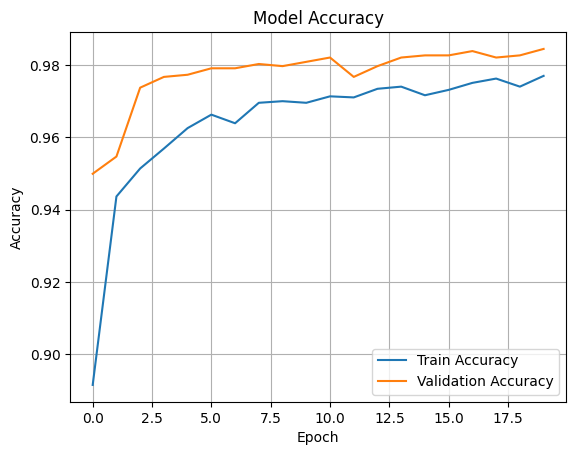

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model.save("my_model.h5")

# **Domain Adaptation For 2015 twitter bot data!!!!**

In [12]:
import os
os.listdir()

['.config',
 'friends.csv',
 '.ipynb_checkpoints',
 'data',
 'users.csv',
 'bot_detection_data.csv',
 'tweets.csv',
 'my_model.h5',
 'followers.csv',
 'untitled',
 'sample_data']

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Epoch 1/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9549 - loss: 0.1346 - val_accuracy: 0.9566 - val_loss: 0.0955
Epoch 2/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9766 - loss: 0.0636 - val_accuracy: 0.9970 - val_loss: 0.0135
Epoch 3/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9789 - loss: 0.0580 - val_accuracy: 0.9860 - val_loss: 0.0292
Epoch 4/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9820 - loss: 0.0500 - val_accuracy: 0.9974 - val_loss: 0.0136
Epoch 5/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9835 - loss: 0.0447 - val_accuracy: 0.9843 - val_loss: 0.0294
Epoch 6/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9823 - loss: 0.0493 - val_accuracy: 0.9941 - val_loss: 0.0127
Epoch 7/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9836 - loss: 0.0484 - val_accuracy: 0.9861 - val_loss: 0.0263
Epoch 8/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accurac

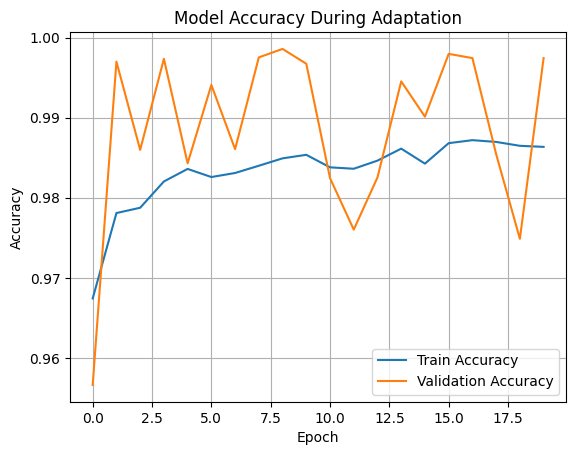

Model saved as my_model_2015adapt.h5


In [17]:
df = pd.read_csv("bot_detection_data.csv")
df.columns = df.columns.str.strip()

df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce", utc=True)

user_features = df.groupby("User ID").agg({
    "Tweet": lambda x: x.str.len().mean(),
    "Retweet Count": "mean",
    "Mention Count": "mean",
    "Follower Count": "mean",
    "Verified": lambda x: x.astype(int).mode()[0],
    "Bot Label": "max",
    "Location": lambda x: x.notna().astype(int).mode()[0],
    "Created At": "min"
}).rename(columns={
    "Tweet": "avg_tweet_length",
    "Retweet Count": "avg_retweets",
    "Mention Count": "avg_mentions",
    "Follower Count": "follower_count",
    "Verified": "is_verified",
    "Location": "has_location"
})

user_features["account_age_days"] = (pd.Timestamp.utcnow() - user_features["Created At"]).dt.days
user_features.drop(columns=["Created At"], inplace=True)

X_new_partial = user_features[[
    "avg_tweet_length", "avg_retweets", "avg_mentions",
    "follower_count", "is_verified", "has_location", "account_age_days"
]].fillna(0)

y_new_true = user_features["Bot Label"].values

#align features
required_features = [
    'age', 'has_location', 'is_verified', 'total_tweets',
    'total_following', 'total_followers', 'total_likes',
    'has_avatar', 'has_background', 'is_protected'
]

X_new_fixed = pd.DataFrame(0, index=X_new_partial.index, columns=required_features)

X_new_fixed['age'] = X_new_partial['account_age_days']
X_new_fixed['has_location'] = X_new_partial['has_location']
X_new_fixed['is_verified'] = X_new_partial['is_verified']
X_new_fixed['total_followers'] = X_new_partial['follower_count']

X_new_fixed = X_new_fixed.fillna(0)

# Load original model
model = load_model("my_model.h5")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_new_scaled = scaler.transform(X_new_fixed)


pseudo_probs = model.predict(X_new_scaled)
pseudo_labels = (pseudo_probs > 0.5).astype(int)

# Combine original + new dataset 2023
X_adapted = np.vstack([X_train_scaled, X_new_scaled])
y_adapted = np.vstack([y_train.reshape(-1, 1), pseudo_labels])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_adapted, y_adapted, epochs=20, batch_size=64, validation_split=0.2)

#plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Adaptation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

model.save("my_model_2023adapt.h5")
print("Model saved as my_model_2023adapt.h5")